# MODULES

## Load data/images

In [1]:
import os
from PIL import Image

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img1 = get_image('data/cat.png')
img2 = get_image('data/ski.png')

### Pre-Process data

In [2]:
import torch
from torchvision.transforms import transforms

def get_input_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])      
    ])    

    return transf

# transform the data
transf = get_input_transform()
input1 = transf(img1).unsqueeze(0)
input2 = transf(img2).unsqueeze(0)
# concat the input size
inputs = torch.cat((input1,input2),dim=0)

## Import model

In [3]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F

# Define model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()

# calculate logits and visualize top5 preds
for _i,img in enumerate(inputs):
    print("\nImage {}...".format(_i))
    logits = model(img.unsqueeze(0))
    probs = F.softmax(logits, dim=1).squeeze()
    p, c = probs.topk(5)
    [print("Class idx:{} has probability: {:.3f}".format(c[_i],p[_i])) for _i in range(p.shape[0])]


Image 0...
Class idx:282 has probability: 0.127
Class idx:281 has probability: 0.092
Class idx:285 has probability: 0.033
Class idx:457 has probability: 0.023
Class idx:265 has probability: 0.021

Image 1...
Class idx:795 has probability: 0.404
Class idx:796 has probability: 0.008
Class idx:746 has probability: 0.004
Class idx:970 has probability: 0.003
Class idx:733 has probability: 0.002


## Ensemble

In [4]:
from captum.attr import IntegratedGradients, GradientShap, Saliency, Lime
# select the target
target_class_id = 795

# calculate explanations
ig = IntegratedGradients(model).attribute(inputs, target=target_class_id)
sal = Saliency(model).attribute(inputs, target=target_class_id)
lime = Lime(model).attribute(inputs, target=target_class_id)


/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1101: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(
/home/109499@TRI.LAN/Github/fork_EnsembleXAI/.venv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1115: UserWarning:

In [5]:
import warnings
warnings.filterwarnings("ignore") # Ignore all warning
from EnsembleXAI.Ensemble import normEnsembleXAI

explanations = torch.stack([ig, lime, sal], dim=1) # on first dim num_images, then num_xai
agg = normEnsembleXAI(explanations, aggregating_func='avg')

print('***Inputs \ndim:{} shape:{}'.format(inputs.dim(),inputs.shape))
print('***IntegratedGradients method \ndim:{} shape:{}'.format(ig.dim(),ig.shape))
print('***Ensemble XAI \ndim:{} shape:{}'.format(explanations.dim(),explanations.shape))
print('***Agg normXAI XAI \ndim:{} shape:{}'.format(agg.dim(),agg.shape))

***Inputs 
dim:4 shape:torch.Size([2, 3, 224, 224])
***IntegratedGradients method 
dim:4 shape:torch.Size([2, 3, 224, 224])
***Ensemble XAI 
dim:5 shape:torch.Size([2, 3, 3, 224, 224])
***Agg normXAI XAI 
dim:4 shape:torch.Size([2, 3, 224, 224])


## Metrics

In [6]:
from EnsembleXAI.Metrics import consistency

# get two explanations
explanation1 = ig
explanation2 = sal # 2,3,32,32
explanations = torch.stack([explanation1, explanation2], dim=1) # expected shape: [num_images, num_explanations, channeld,h,w]

for _i,one_image in enumerate(explanations):
    # Calculate consistency for the two explanations
    con = consistency(one_image)
    print(f"Consistency of image {_i}: {con}")

Consistency of image 0: 0.12893833220005035
Consistency of image 1: 0.09148313850164413


## Normalization

In [7]:
from EnsembleXAI.Normalization import mean_var_normalize,median_iqr_normalize,second_moment_normalize

# get two explanations
explanation1 = ig
explanation2 = sal
# stack them
explanations = torch.stack([explanation1, explanation2], dim=1) # expected shape: [num_images, num_explanations, channeld,h,w]
# explanations = torch.randn(1,1, 3, 64, 64)

# Scale an explanation using Normal Standardization
normal_std = mean_var_normalize(explanations)
# Scale an explanation using Robust Standardization
robust_std = median_iqr_normalize(explanations)
# Scale an explanation using Second Moment Scaling
scaled_explanation = second_moment_normalize(explanations)

## Visualization of feature/heat-maps

In [8]:
from captum.attr import visualization as viz # for visualization

def show_attr(attr_map,method='heat_map',orig_img=None,title=None,sign='all'):
    viz.visualize_image_attr(
        attr = attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        original_image = orig_img.permute(1, 2, 0).numpy() if orig_img is not None else None,
        method=method,
        sign=sign,
        show_colorbar=True,
        title=title,
    )
    
"""
sign (str, optional)
Chosen sign of attributions to visualize. Supported options are:
    positive - Displays only positive pixel attributions.
    absolute_value - Displays absolute value of attributions.
    negative - Displays only negative pixel attributions.
    all - Displays both positive and negative attribution values. This is not supported for masked_image or alpha_scaling modes, since signed information cannot be represented in these modes
method (str, optional)
Chosen method for visualizing attribution. Supported options are:
    heat_map - Display heat map of chosen attributions
    blended_heat_map - Overlay heat map over greyscale version of original image. Parameter alpha_overlay corresponds to alpha of heat map.
    original_image - Only display original image.
    masked_image - Mask image (pixel-wise multiply) by normalized attribution values.
    alpha_scaling - Sets alpha channel of each pixel to be equal to normalized attribution value.
"""

'\nsign (str, optional)\nChosen sign of attributions to visualize. Supported options are:\n    positive - Displays only positive pixel attributions.\n    absolute_value - Displays absolute value of attributions.\n    negative - Displays only negative pixel attributions.\n    all - Displays both positive and negative attribution values. This is not supported for masked_image or alpha_scaling modes, since signed information cannot be represented in these modes\nmethod (str, optional)\nChosen method for visualizing attribution. Supported options are:\n    heat_map - Display heat map of chosen attributions\n    blended_heat_map - Overlay heat map over greyscale version of original image. Parameter alpha_overlay corresponds to alpha of heat map.\n    original_image - Only display original image.\n    masked_image - Mask image (pixel-wise multiply) by normalized attribution values.\n    alpha_scaling - Sets alpha channel of each pixel to be equal to normalized attribution value.\n'

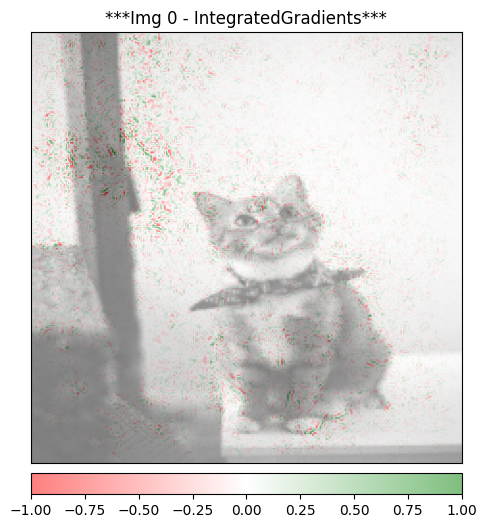

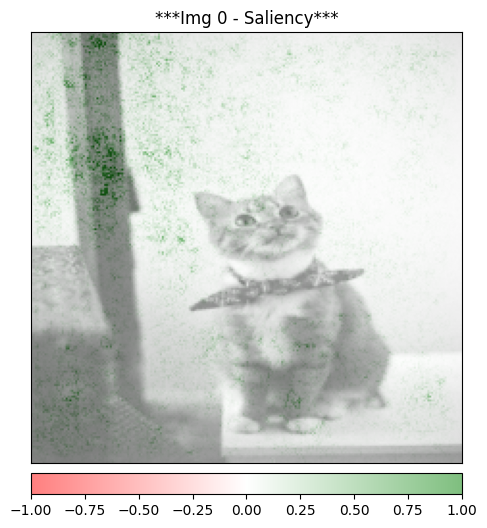

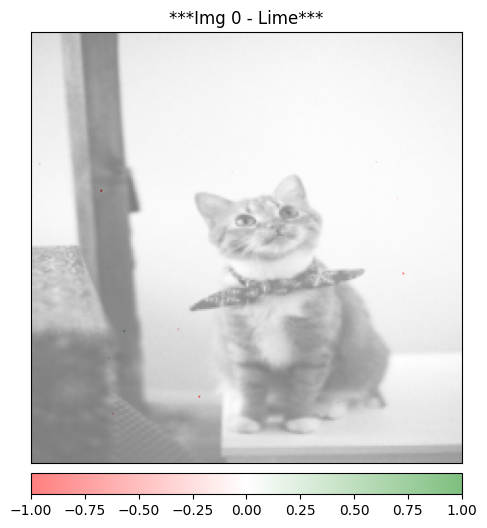

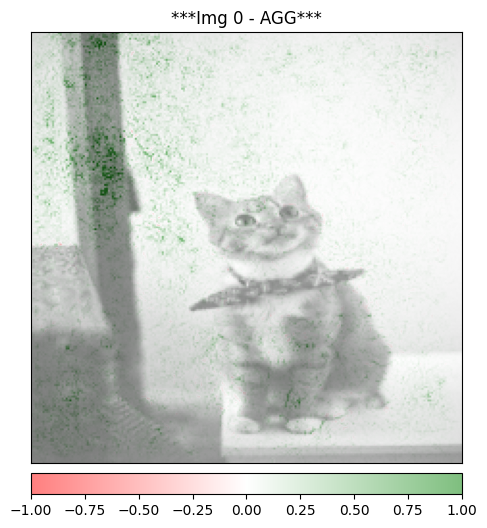

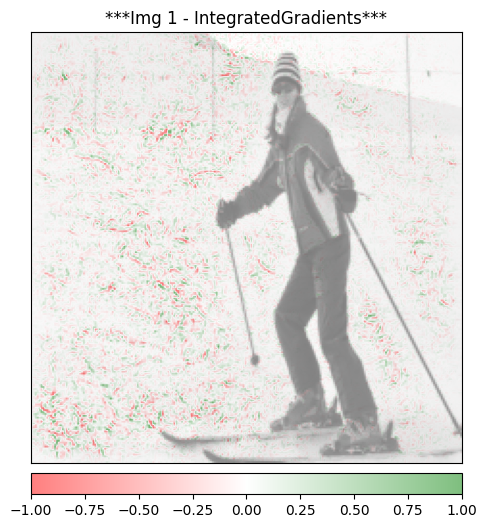

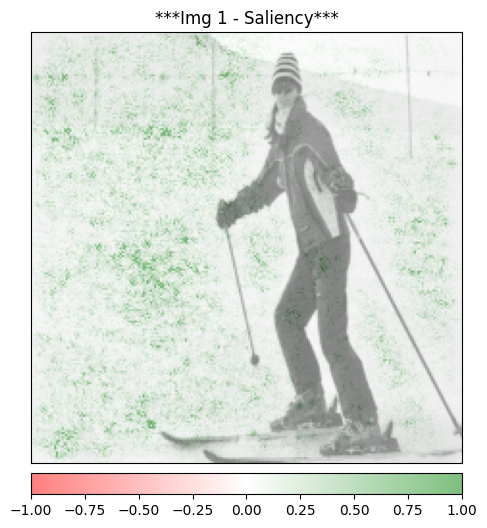

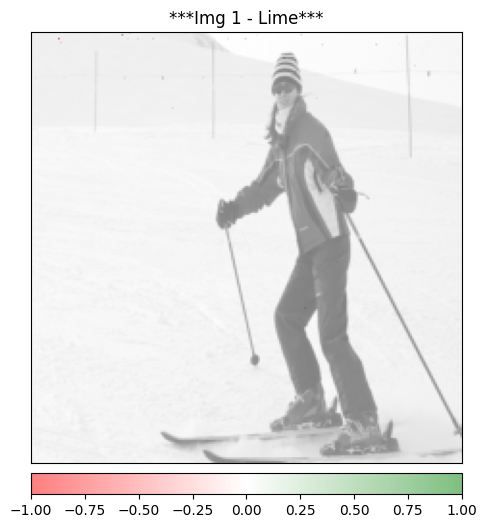

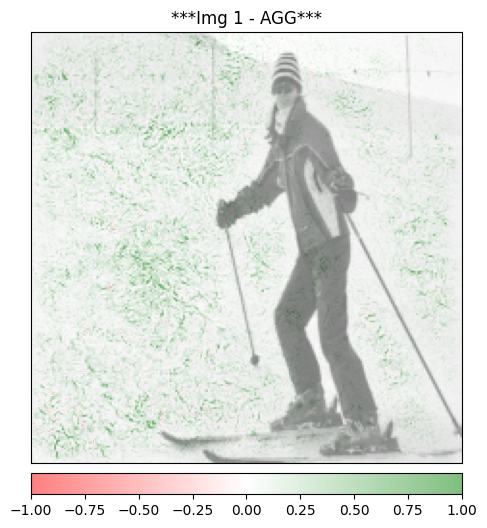

In [9]:
for _i,img in enumerate(inputs):
    show_attr(attr_map=ig[_i],method='blended_heat_map',orig_img=img,
              title='***Img {} - IntegratedGradients***'.format(_i))
    show_attr(attr_map=sal[_i],method='blended_heat_map',orig_img=img,
              title='***Img {} - Saliency***'.format(_i))
    show_attr(attr_map=lime[_i],method='blended_heat_map',orig_img=img,
              title='***Img {} - Lime***'.format(_i))
    show_attr(attr_map=agg[_i],method='blended_heat_map',orig_img=img,
            title='***Img {} - AGG***'.format(_i))

## Re-do it only for LIME

Segmentation IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
Segmentation shape: torch.Size([224, 224])


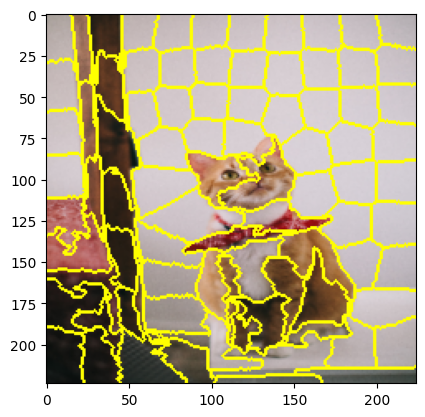

In [10]:
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt

# process data for segmenter
input_img_tensor = transf(img1)
seg_data_format = input_img_tensor.permute(1, 2, 0).numpy()

# segment!
segmenter = slic(image=seg_data_format ,n_segments=100)
seg_mask=torch.tensor(segmenter) # to torch

seg_ids = sorted(seg_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)
print('Segmentation shape:', seg_mask.shape)

# visualize segmentation with original image
img_wboundaries = mark_boundaries(seg_data_format, segmenter)
plt.imshow(img_wboundaries)



In [11]:
# map segment IDs to feature group IDs
feature_mask = seg_mask.clone()
for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i
    
print('Feature mask:', feature_mask)
print('Feature mask IDs:', feature_mask.unique().tolist())
print('Feature mask shape:',feature_mask.shape)

Feature mask: tensor([[ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        ...,
        [77, 77, 77,  ..., 82, 82, 82],
        [77, 77, 77,  ..., 82, 82, 82],
        [77, 77, 77,  ..., 82, 82, 82]])
Feature mask IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
Feature mask shape: torch.Size([224, 224])


### LIME: configuration

In [12]:
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)
lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

#### Select target and learn!

In [13]:
label_idx = 282
# lime = Lime(model).attribute(inputs, target=target_class_id)

print("Input data of shape: {} and feature masks: {}"
      .format(input_img_tensor.unsqueeze(0).shape, feature_mask.unsqueeze(0).shape ))

attrs = lr_lime.attribute(
    input_img_tensor.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=1000,
    perturbations_per_eval=64,
    show_progress=True
).squeeze(0)

Input data of shape: torch.Size([1, 3, 224, 224]) and feature masks: torch.Size([1, 224, 224])


Lime attribution: 100%|██████████| 16/16 [00:33<00:00,  2.08s/it]


#### Visualize result

torch.Size([3, 224, 224])


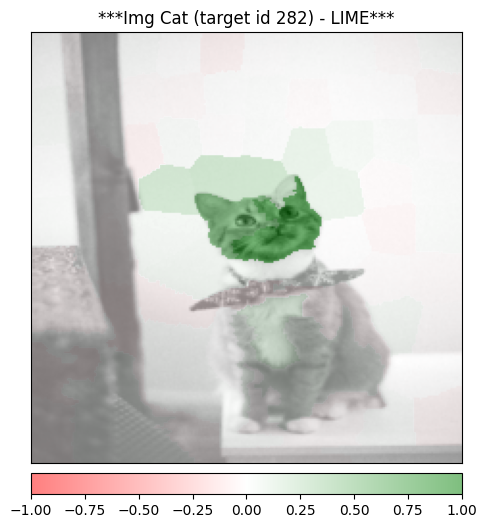

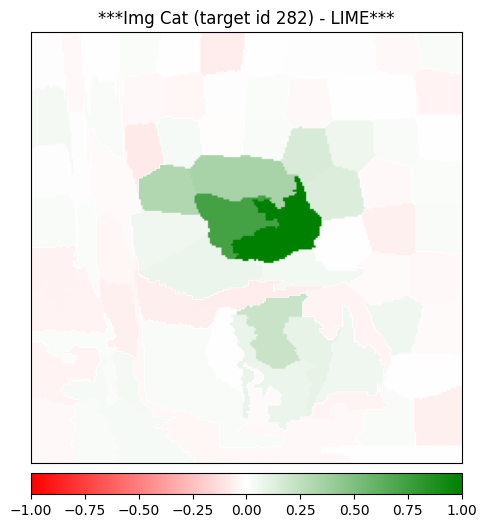

In [15]:
print(attrs.shape)
show_attr(attr_map=attrs,method='blended_heat_map', orig_img = input_img_tensor, sign='all',
            title='***Img Cat (target id 282) - LIME***')
show_attr(attr_map=attrs,method='heat_map', orig_img = input_img_tensor, sign='all',
            title='***Img Cat (target id 282) - LIME***')